<a href="https://colab.research.google.com/github/SamuelXJames/Auto-Music-Seperation/blob/main/preprocessing/C_U_NETData_toTFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert Images Into TFRecords

This code converts spectrograms (or scalograms) stored as PNG images on Google Cloud Storage to TFRecords (as byte data). The dataset/TFRecords are **structured specfically for C-U-NET**

## Connect to Google Cloud Storage (GCS)

The images are stored on a GCS bucket. Alternatively, they can be stored locally or on Google Drive 



In [ ]:
## IGNORE if storing kerenels locally or on Google Drive
#Authenticare access to cloud storage
!gcloud auth login

#Set current GCS project
!gcloud config set project superres000

In [2]:
## IGNORE if storing kerenels locally or on Google Drive
#Setup google cloud sdk (seems to be necessary but could be redudant)
from google.colab import auth
auth.authenticate_user()

## Import Libraries 

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import os, sys, math, glob, ntpath, time, random
from PIL import Image
from datetime import timedelta
from tqdm import tqdm


## Collect Mixes and Stems

Collects the filenames for all the stems and mixes

In [4]:
# Directories
MIXDOWN_DIR = 'gs://super_res_train/Mixdown/'
BASS_DIR = 'gs://super_res_train/Bass/'
DRUM_DIR = 'gs://super_res_train/Drums/'
VOCAL_DIR = 'gs://super_res_train/Vocals/'
OTHER_DIR = 'gs://super_res_train/Other/'
CLASSES = [b'Bass', b'Drums', b'Vocals', b'Other']
img_format = '*.png'

# Get Filenames
Mixdown_files = tf.io.gfile.glob(MIXDOWN_DIR + img_format)
Bass_files = tf.io.gfile.glob(BASS_DIR + img_format)
Drum_files = tf.io.gfile.glob(DRUM_DIR + img_format)
Vocal_files = tf.io.gfile.glob(VOCAL_DIR + img_format)
Other_files = tf.io.gfile.glob(OTHER_DIR + img_format)


# Number of Images
num_Mixdown = len(Mixdown_files) 
num_Bass = len(Bass_files)
num_Drum = len(Drum_files) 
num_Vocal = len(Vocal_files)
num_Other = len(Other_files) 

print('Number of Mixdown Images {}'.format(num_Mixdown))
print('Number of Bass Images {}'.format(num_Bass))
print('Number of Drum Images {}'.format(num_Drum))
print('Number of Vocal Images {}'.format(num_Vocal))
print('Number of Other Images {}'.format(num_Other))


Number of Mixdown Images 2
Number of Bass Images 2
Number of Drum Images 2
Number of Vocal Images 2
Number of Other Images 2


## Check Image Size
Confirms that each image in a dataset entry (ie. each steam and mix) have the same shape.



In [5]:
def check_img_shapes(Mixdown_files,Bass_files,Drum_files,Vocal_files,Other_files):
  valid = True
  for (Mixdown_file,Bass_file,Drums_file,Vocals_file,Other_file) in zip(Mixdown_files,Bass_files,Drum_files,Vocal_files,Other_files):
    Mixdown_shape = np.shape(tf.image.decode_png(tf.io.read_file(Mixdown_file)))
    Bass_shape = np.shape(tf.image.decode_png(tf.io.read_file(Bass_file)))
    Drums_shape = np.shape(tf.image.decode_png(tf.io.read_file(Drums_file)))
    Vocals_shape = np.shape(tf.image.decode_png(tf.io.read_file(Vocals_file)))
    Other_shape = np.shape(tf.image.decode_png(tf.io.read_file(Other_file)))
    print('Mixdown \t Bass \t Drums \t Vocals \t Others')
    if not(Mixdown_shape == Bass_shape == Drums_shape == Vocals_shape == Other_shape):
      _,Mixdown_name = ntpath.split(Mixdown_file)
      _,Bass_name = ntpath.split(Bass_file)
      _,Drums_name = ntpath.split(Drums_file)
      _,Vocals_name = ntpath.split(Vocals_file)
      _,Other_name = ntpath.split(Other_file)
      print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'.format(Mixdown_name,
                                                            Mixdown_shape,
                                                            Bass_name,
                                                            Bass_shape,
                                                            Drums_name,
                                                            Drums_shape,
                                                            Vocals_name,
                                                            Vocals_shape,
                                                            Other_name,
                                                            Other_shape))
      valid = False
      
      

  if valid:
    print('All Image Shapes Match')

check_img_shapes(Mixdown_files,Bass_files,Drum_files,Vocal_files,Other_files)

    
                                            
                                                     

Mixdown 	 Bass 	 Drums 	 Vocals 	 Others
Mixdown 	 Bass 	 Drums 	 Vocals 	 Others
All Image Shapes Match


## View Images

Mixdown, Bass, Drum, Vocal, Other


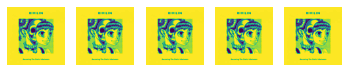

In [6]:
def view_sample_imgs(Mixdown_files,Bass_files,Drum_files,Vocal_files,Other_files):
  # View some of the images
  #sample = np.random.randint(int(len(Mixdown_files)-1),size = 1)
  sample = [0]
  count = 1
  images = []
  print('Mixdown, Bass, Drum, Vocal, Other')


  for val in sample:
    plt.subplot(1,5,1)
    Mixdown_image = tf.image.decode_png(tf.io.read_file(Mixdown_files[val]))
    plt.imshow(Mixdown_image.numpy().squeeze(axis=2))
    plt.axis('off')

    plt.subplot(1,5,2)
    Bass_image = tf.image.decode_png(tf.io.read_file(Bass_files[val]))
    plt.imshow(Bass_image.numpy().squeeze(axis=2))
    plt.axis('off')

    plt.subplot(1,5,3)
    Drum_image = tf.image.decode_png(tf.io.read_file(Drum_files[val]))
    plt.imshow(Drum_image.numpy().squeeze(axis=2))
    plt.axis('off')

    plt.subplot(1,5,4)
    Vocal_image = tf.image.decode_png(tf.io.read_file(Vocal_files[val]))
    plt.imshow(Vocal_image.numpy().squeeze(axis=2))
    plt.axis('off')

    plt.subplot(1,5,5)
    Other_image = tf.image.decode_png(tf.io.read_file(Other_files[val]))
    plt.imshow(Other_image.numpy().squeeze(axis=2))
    plt.axis('off')

view_sample_imgs(Mixdown_files,Bass_files,Drum_files,Vocal_files,Other_files)
  


## Create TF Dataset

In [7]:
# Read files
def decode_png_and_label(filename):
  Mixdown_filename = filename[0]
  instrument_filename = filename[1]
  label = filename[2]
  
  Mixdown_image = tf.io.read_file(Mixdown_filename)
  instrument_image = tf.io.read_file(instrument_filename)
 
  
  return Mixdown_image, label, instrument_image




# Bass Files
num_repeats = np.shape(Mixdown_files)[0]
files = [val for pair in zip(Mixdown_files,Bass_files,np.repeat(['Bass'],num_repeats)) for val in pair]
Bass_list = np.reshape(files,(-1,3),order = 'C')

# Drums Files
files = [val for pair in zip(Mixdown_files,Drum_files,np.repeat(['Drums'],num_repeats)) for val in pair]
Drum_list = np.reshape(files,(-1,3),order = 'C')

# Vocals Files
files = [val for pair in zip(Mixdown_files,Vocal_files,np.repeat(['Vocals'],num_repeats)) for val in pair]
Vocals_list = np.reshape(files,(-1,3),order = 'C')

# Other Files
files = [val for pair in zip(Mixdown_files,Other_files,np.repeat(['Other'],num_repeats)) for val in pair]
Other_list = np.reshape(files,(-1,3),order = 'C')

# Complete List
random_list = np.arange(num_repeats*4)
np.random.shuffle(random_list)
complete_list = np.concatenate((Bass_list,Drum_list,Vocals_list,Other_list))
complete_list = complete_list[random_list] # Randomize


# Dataset
AUTO = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices(complete_list)


# Add Files to the TF Dataset
dataset = dataset.map(decode_png_and_label,num_parallel_calls=AUTO)



## Confrim Dataset

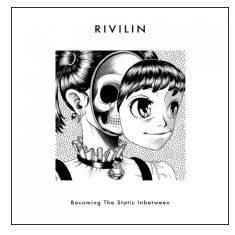

In [9]:
# Confirm Labels
for (Mixdown_image,label,instrument_image) in dataset.take(1):
  plt.figure()
  plt.imshow(tf.image.decode_png(Mixdown_image).numpy().squeeze(axis=2),cmap='gray') 
  plt.xticks([])
  plt.yticks([])
  
  
  
  

## Get Image Shape
Returns the shape of the Spectrogram. Used in the TFRecord filename.

In [11]:
def get_shape(dataset):
  for (Mixdown,_,_) in dataset.take(1):
    image_shape = np.shape(tf.image.decode_png(Mixdown))

    return image_shape.as_list()

image_shape = get_shape(dataset)
print('Image Shape: {}'.format(image_shape))

Image Shape: [715, 715, 1]


## TF Record Config.
- **GCS_OUTPUT**: Output folder to save TFRecrods
- **img_shard**: Number of data entries in a single TFRecord
 - A single data entry consists of:
 - (Mixed Spectrogram, label, Instrument Spectrogram)
- Try to get each TFRecord to be beteween 200 MB - 1 GB
- **Files**: Number of TFRecords that will be generated
- **Excess Images**: Number of data entries that will be placed in the last TFRecord
 - Because the number of data entries may not be evenly divisible by img_shard the last file will have a different number of data entries. That is OK.
 


In [13]:
GCS_OUTPUT = 'gs://super_res_train/TFRecords/'

#images per TF Record shard
img_shard = 8

num_shards = len(Mixdown_files*4)/img_shard
if num_shards != np.floor(num_shards):
  excess = len(LR_patches) % img_shard
  num_shards = np.floor(num_shards)
else:
  excess = 0
  
print('Files: {}\nExcess Images: {}'.format(num_shards,excess))

# Shuffle and Batch Dataset
dataset2 = dataset.batch(img_shard, drop_remainder=False)

Files: 1.0
Excess Images: 0


## Write dataset to a TF Record

In [35]:
# Writes TFDataset to a TF Record
def writeTFRecord(writer,Mixdown,label,Instrument):
  class_num = np.argmax(np.array(CLASSES)==label) 
  one_hot_class = np.eye(len(CLASSES))[class_num]

  example = tf.train.Example(features=tf.train.Features(feature={
        'Mixdown': tf.train.Feature(bytes_list=tf.train.BytesList(value=[Mixdown])),
        'Label': tf.train.Feature(float_list=tf.train.FloatList(value = one_hot_class.tolist())),
        'Instrument': tf.train.Feature(bytes_list=tf.train.BytesList(value=[Instrument])),
        
    
        
        
    }))
  
  return example


#Write TF Records
options = tf.io.TFRecordOptions(compression_type = 'ZLIB',
                                compression_level = 9)

                               
for shard,(Mixdown,label,instrument) in enumerate(dataset2):
  shard_size = Mixdown.numpy().shape[0]
  filename = GCS_OUTPUT + '{:02d}_W{}H{}N{}_SRImages.tfrec'.format(shard,image_shape[0],image_shape[1],shard_size)
  with tf.io.TFRecordWriter(filename, options = options) as out_file:
    for i in range(shard_size):
      example = writeTFRecord(out_file,
                              Mixdown.numpy()[i],
                              label.numpy()[i],
                              instrument.numpy()[i])
      out_file.write(example.SerializeToString())
    print('Completed: {}/{} Wrote File: {}'.format(shard+1,int(num_shards),filename))

    
  
  
  


Completed: 1/1 Wrote File: gs://super_res_train/TFRecords/00_W715H715N8_SRImages.tfrec


## Read the TFRecrods

In [53]:
# Select TFRrecord to read
AUTO = tf.data.experimental.AUTOTUNE
GCS_File = 'gs://super_res_train/TFRecords/00_W715H715N8_SRImages.tfrec'
img_shard = int(GCS_File[GCS_File.find('N')+1:GCS_File.rfind('_')])
dataset3 = tf.data.TFRecordDataset(GCS_File,  compression_type='ZLIB',
                                   num_parallel_reads=AUTO)
nb_images = img_shard
w = int(GCS_File[GCS_File.find('W')+1:GCS_File.rfind('H')])
h = int(GCS_File[GCS_File.find('H')+1:GCS_File.rfind('N')])
IMG_SHAPE = [w,h]
NUM_CHANNELS = 1


def read_tfrecord(example):
# Create a dictionary describing the features.
  features = {
      'Mixdown': tf.io.FixedLenFeature([], tf.string),
      'Label': tf.io.VarLenFeature(tf.float32),
      'Instrument': tf.io.FixedLenFeature([], tf.string)
      
  }
  
  example = tf.io.parse_single_example(example, features)

  Mixdown = tf.io.decode_png(example['Mixdown'])
  Mixdown = tf.reshape(Mixdown, [IMG_SHAPE[0],IMG_SHAPE[1], NUM_CHANNELS])
  
  Label = tf.sparse.to_dense(example['Label'])
  Label = tf.reshape(Label,[4,1])

  Instrument = tf.io.decode_png(example['Instrument'])
  Instrument = tf.reshape(Instrument, [IMG_SHAPE[0],IMG_SHAPE[1], NUM_CHANNELS])
  
  return Mixdown,Label,Instrument

dataset3 = dataset3.map(read_tfrecord)
instruments = ['Bass','Drums','Vocals','Other']
print('Instrument Track Names:')
for (a,b,c) in dataset3.take(8):
  print(instruments[int(np.where(b == 1)[0])])
  
   






Instrument Track Names:
Bass
Drums
Bass
Vocals
Other
Drums
Vocals
Other
